In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

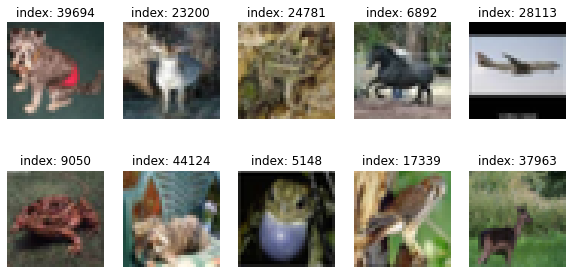

In [3]:
plt.figure(figsize=(10, 5))
for i in range(10):
    rn = np.random.randint(len(train_x))
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[rn])
    plt.title(f'index: {rn}')
    plt.axis('off')
plt.show()

In [4]:
train_x = (train_x - 127.5) / 127.5
train_x.max(), train_x.min()

(1.0, -1.0)

In [28]:
BUFFER_SIZE = len(train_x)
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x, )
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

## Modeling

In [6]:
INPUT_SHAPE = (32, 32, 3) # RGB 3channel

In [7]:
def make_generator_model():
    
    '''
    Generator model
    
    random noise -> generative image
    
    n = batch_size
    input shape = (n, 100)
    output shape = (n, 32,32,3)
    
    dense input = 8*8*256 = 16384
    '''
    
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, 256))) #Reshape for images

    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), padding='same', use_bias=False, activation='tanh')) #RGB 3Channel!
    
    return model

In [8]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       524288    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262144    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0

- generative model이 잘 동작하는지 확인해보자.
- 랜덤 노이즈를 통해 (32,32,3) image를 생성한다.

(1, 32, 32, 3)


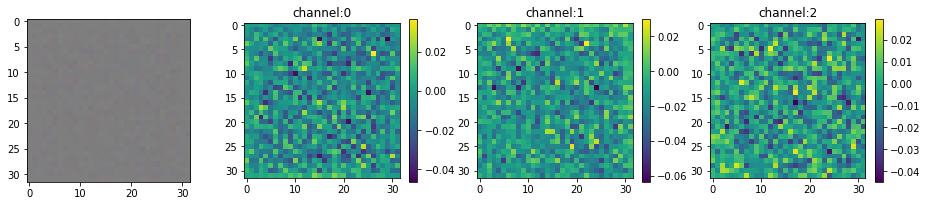

In [10]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.figure(figsize=(16, 3))
plt.subplot(1, 4, 1)
plt.imshow((generated_image[0, :, :, :]+1)/2)
for i in range(3) :
    plt.subplot(1, 4, (i+1)+1)
    plt.imshow(generated_image[0, :, :, i])
    plt.title("channel:{}".format(i))
    plt.colorbar()
plt.show()

- 학습이 되지 않은 상황이기 때문에 의미없는 이미지가 생성된다.
- 잘 동작하는 것은 확인할 수 있다.
- 유일한 걱정은 cifar10 자체가 low resolution image이기 때문에 유의미한 이미지를 생성할 수 있을지? 인데, 이는 나중에 학습을 통해 확인해보자.

In [11]:
def make_discriminator_model():
    
    '''
    Discriminator model
    
    generative image -> 1-dim vector (discriminative)
    
    n = batch_size
    input shape = (n, 32, 32, 3)
    output shape = (n, 1)
    
    '''

    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=INPUT_SHAPE))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Dense(1))
    
    return model

In [12]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)        

In [13]:
test_discriminate = discriminator(generated_image, training=False)
test_discriminate

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00094112]], dtype=float32)>

## Optimization

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Training

In [19]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [20]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generator가 이미지를 생성
        generated_images = generator(noise, training=True)
        
        # discriminator가 실제 입력받은 이미지로는 real_output
        # 위에서 생성한 이미지에 대해서는 fake_output을 계산해서 return
        real_output = discriminator(images, training=True) # f(x^i) in paper fomula
        fake_output = discriminator(generated_images, training=True) #f(G(z^i)) in paper fomula
        
        # generator의 loss는 fake_output으로만 계산
        # discriminator의 loss는 real_output, fake_output 두 개를 받아서 연산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # accuracy계산해서 real, fake에 대한 accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    # gradient를 계산하는 부분, gen+tape와 disc_tape를 활용해서 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 위에서 계산된 optimzer에 입력해서 가중치를 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [21]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
               .format(os.getenv('HOME'), epoch, it))
    
    plt.show()

In [22]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지파일로 저장한다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04}.png'
               .format(os.getenv("HOME"), epoch))
    plt.show()

In [23]:
checkpoint_dir = os.getenv("HOME") + '/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [24]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time() - start)))
        
        draw_train_history(history, epoch)

In [25]:
save_every = 10
EPOCHS = 100

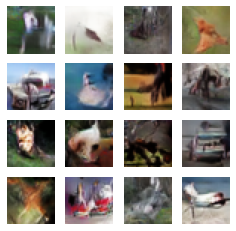

Time for training : 4210 sec


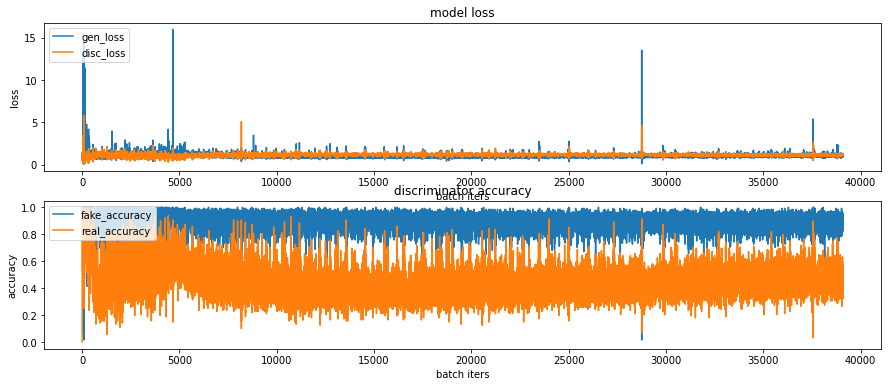

CPU times: user 1h 11min 47s, sys: 3min 42s, total: 1h 15min 30s
Wall time: 1h 10min 13s


In [29]:
%%time
train(train_dataset, EPOCHS, save_every)

In [30]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1904109 Feb  8 03:00 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


## Improvements

- GAN의 문제점은 discriminator와 generator간의 균형을 유지하며 학습하기 어렵고, 학습이 완료된 이후에도 mode dropping이 발생한다는 것이다. 이러한 문제가 발생하는 이유는, discriminator가 선생님 역할을 충분히 해 주지 못해 모델이 최적점까지 학습되지 못했기 때문이다.

- Wasserstein GAN에서는 이러한 문제점을 해결하기 위하여 기존의 GAN에 비해 아래와 같은 차이점을 둔다.
- discriminator대신 새로 정의한 critic을 사용한다. discriminator는 가짜/진짜를 판별하기 위해 sigmoid를 사용하고, output은 가짜/진짜에 대한 예측 확률 값이다.
- 반면 critic은 EM(Earth Mover) distance로부터 얻은 scalar 값을 이용한다.
- EM distance는 확률 분포 간의 거리를 측정하는 척도 중 하나인데, 그 동안 일반적으로 사용된 척도는 KL divergence이다. KL divergence는 매우 strict 하게 거리를 측정하는 방법이라서, continuous하지 않은 경우가 있고 학습시키기 어렵다.

결과적으로, GAN의 discriminator보다 선생님 역할을 잘 할 수 있는 critic을 사용함으로써 gradient를 잘 전달시키고 critic과 generator를 최적점까지 학습할 수 있다는 것이다. 때문에 아래와 같은 이점을 얻을 수 있다고 주장한다.

- training 시 discriminator와 generator간의 balance를 주의깊게 살피고 있지 않아도 된다.
- GAN에서 일반적으로 발생되는 문제인 mode dropping을 해결 가능하다.

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [33]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

In [36]:
IMG_SHAPE = (32, 32, 3)

def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 36, 36, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)        4864      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 128)         204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 9, 9, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 9, 128)       

In [40]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 3, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    #x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_8 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         29

In [52]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

tf.cast(train_x, dtype=tf.float32) # data type change float64 -> float 32

# Start training the model.
wgan.fit(train_x, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/20
391/391 [==============================] - 168s 416ms/step - d_loss: -4.9294 - g_loss: 10.2741
Epoch 2/20
391/391 [==============================] - 172s 441ms/step - d_loss: -3.1774 - g_loss: -2.9654
Epoch 3/20
391/391 [==============================] - 173s 443ms/step - d_loss: -2.8479 - g_loss: -3.6700
Epoch 4/20
391/391 [==============================] - 173s 442ms/step - d_loss: -2.7194 - g_loss: -3.2740
Epoch 5/20
391/391 [==============================] - 173s 442ms/step - d_loss: -1.9728 - g_loss: -4.3293
Epoch 6/20
391/391 [==============================] - 172s 441ms/step - d_loss: -1.9584 - g_loss: 0.8472
Epoch 7/20
391/391 [==============================] - 173s 443ms/step - d_loss: -1.5976 - g_loss: -0.4434
Epoch 8/20
391/391 [==============================] - 172s 441ms/step - d_loss: -1.3734 - g_loss: -6.0785
Epoch 9/20
391/391 [==============================] - 172s 441ms/step - d_loss: -1.6423 - g_loss: -1.9607
Epoch 10/20
391/391 [==========================

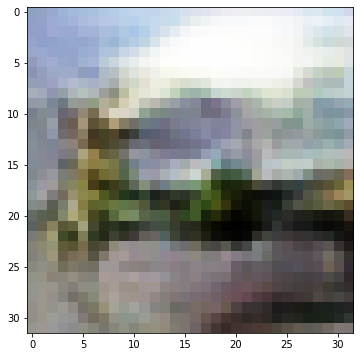

In [53]:
import matplotlib.image as img

image = img.imread('./generated_img_2_19.png')
plt.imshow(image)

## Reference

- https://keras.io/examples/generative/wgan_gp/
- https://arxiv.org/pdf/1701.07875.pdf